# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

- demand.csv 
- network_pos.csv
- network_weight.csv
- rel_cost.csv 倉庫と工場間の輸送コスト
- supply.csv
- tbl_factory.csv 生産工場データ
- tbl_transaction.csv 2019年の工場への部品輸送実績
- tbl_warehouse.csv 倉庫データ
- trans_cost.csv
- trans_route.csv
- trans_route_new.csv
- trans_route_pos.csv
 

In [1]:
%matplotlib inline
import pandas as pd


In [2]:
df_cost = pd.read_csv("rel_cost.csv", index_col=0)
df_factory = pd.read_csv("tbl_factory.csv", index_col=0)
df_transaction = pd.read_csv("tbl_transaction.csv",index_col=0)
df_warehouse = pd.read_csv("tbl_warehouse.csv",index_col=0)

In [3]:
df_cost.head() # FCID 工場データ、 WHID 倉庫データ Cost 

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
df_transaction.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [5]:
df_factory.head() 

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北


In [6]:
df_warehouse.head()

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北


In [7]:
# df_transaction に df_cost をマージして、それぞれの輸送コストを確認
df_transaction_cost = df_transaction.merge(df_cost, left_on=["ToFC", "FromWH"], right_on=["FCID", "WHID"], how="left")
df_transaction_cost.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [8]:
# 工場データ追加
df_transaction_cost = df_transaction_cost.merge(df_factory, right_index=True, left_on="ToFC", how="left")
df_transaction_cost.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [9]:
# 倉庫データ追加
df_transaction_cost = df_transaction_cost.merge(df_warehouse, right_index=True, left_on="FromWH", how="left")
df_transaction_cost.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北,山形倉庫,65,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北,郡山倉庫,60,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東,品川倉庫,41,関東


### ノック５２：現状の輸送量、コストを確認してみよう

In [10]:
# 関東にある倉庫（関東支社）だけのデータ
df_wh_kanto = df_transaction_cost[df_transaction_cost["WHRegion"]=="関東"]
# 東北にある倉庫（東北支社）だけのデータ
df_wh_tohoku = df_transaction_cost[df_transaction_cost["WHRegion"]=="東北"]



In [11]:
df_wh_kanto["Cost"].sum(), df_wh_tohoku["Cost"].sum()

(2189.3, 2062.0)

In [12]:
# 支社毎のcost 総計
df_transaction_cost.groupby("WHRegion")["Cost"].sum()


WHRegion
東北    2062.0
関東    2189.3
Name: Cost, dtype: float64

In [13]:
# 支社毎の送料 総計
df_transaction_cost.groupby("WHRegion")["Quantity"].sum()

WHRegion
東北    50214
関東    49146
Name: Quantity, dtype: int64

In [14]:
# 支社毎の送料平均（/個）
df_transaction_cost.groupby("WHRegion")["Cost"].sum()/df_transaction_cost.groupby("WHRegion")["Quantity"].sum() * 10000

WHRegion
東北    410.642450
関東    445.468604
dtype: float64

In [15]:
# 支社毎のコストを単純に確認
df_factory.merge(df_cost, left_index=True, right_on="FCID", how="left").groupby("FCRegion")["Cost"].mean()

FCRegion
東北    1.050
関東    1.075
Name: Cost, dtype: float64

### ノック５３：ネットワークを可視化してみよう

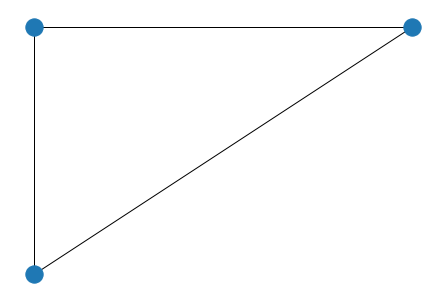

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

G.add_edge("nodeA", "nodeB")
G.add_edge("nodeA", "nodeC")
G.add_edge("nodeB", "nodeC")

pos={}
pos["nodeA"] = (0,0)
pos["nodeB"] = (1,1)
pos["nodeC"] = (0,1)

nx.draw(G, pos)
plt.show()



### ノック５４：ネットワークにノードを追加してみよう

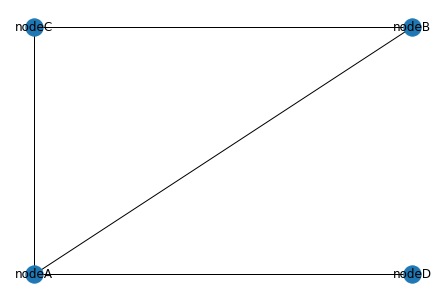

In [17]:
G.add_node("nodeD")
G.add_edge("nodeA","nodeD")
pos["nodeD"]=(1,0)
nx.draw(G, pos, with_labels=True)

### ノック５５：ルートの重みづけを実施しよう

In [18]:
import numpy as np
df_weight=pd.read_csv("network_weight.csv")
df_pos=pd.read_csv("network_pos.csv")


In [19]:
df_weight

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


In [20]:
df_pos

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


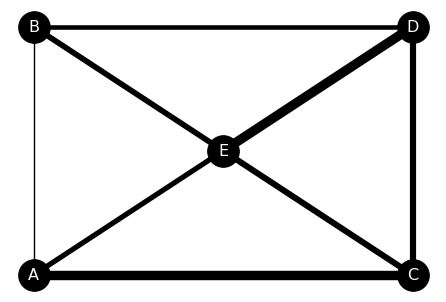

In [21]:
#df_weightをリスト化（Sizeで掛けた後）
size = 10
from itertools import chain
edge_weight = list(chain.from_iterable((df_weight*size).values.tolist()))

G = nx.Graph()

# 頂点の追加
for c in df_weight.columns:
    G.add_node(c)

# 辺の設定
for x in df_weight.columns:
    for y in df_weight.columns:
        G.add_edge(x, y)

# 座標の設定
pos = {c:(df_pos[c][0],df_pos[c][1]) for c in df_pos.columns}

nx.draw(G, pos, with_labels=True, width=edge_weight,font_size=16, node_size = 1000,node_color='k', font_color='w', )






In [26]:
G.edges

EdgeView([('A', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('B', 'B'), ('B', 'C'), ('B', 'D'), ('B', 'E'), ('C', 'C'), ('C', 'D'), ('C', 'E'), ('D', 'D'), ('D', 'E'), ('E', 'E')])

### ノック５６：輸送ルート情報を読み込んでみよう

In [24]:
df_trans_route = pd.read_csv("trans_route.csv", index_col="工場")
df_trans_route.head()
# これがウェイト                             

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

In [27]:
df_trans_route_pos = pd.read_csv("trans_route_pos.csv")
df_trans_route_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [ ]:
# node 追加
from itertools import permutations
G = nx.Graph()


# for x, y in permutations(df_trans_route_pos, 2):
#     G.add_node()

### ノック５８：輸送コスト関数を作成しよう

### ノック５９：制約条件を作ってみよう

### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう